# Imports Iniciais

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m spacy download pt_core_news_sm
!pip install googletrans==4.0.0-rc1
!pip install enelvo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
from googletrans import Translator
from enelvo.normaliser import Normaliser
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from unittest.mock import patch, MagicMock
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import unittest
import numpy as np
import pandas as pd
import spacy
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Pré-processamento

## 0) Base de Dados

In [ ]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/augmented_data.csv')
chats_clients.head()

No                              Intencao  \
0   1                        Como depositar   
1   2                    Como fazer remessa   
2   3                      Tempo de remessa   
3   4  Pedido de envio via metodo "ByPhone"   
4   5  Pedido de envio via metodo "ByPhone"   

                                            Pergunta  \
0  Boa dia.tudo bem?eu gostaria de saber sobre aq...   
1                     Como enviar dinheiro do Japão?   
2  Quanto tempo levará para o beneficiário recebe...   
3  Boa tarde Acabei de fazer a transferência de 2...   
4  Poderia fazer a remessa de 22yenes para o BBB ...   

                                            Resposta  
0  Bom dia! Sim, o sr pode utilizar o cartão de d...  
1  Para se inscrever no serviço de remessa, por f...  
2  Via de regra, as remessas serão pagas via PIX ...  
3  iremos processar a sua solicitacao. Muito obri...  
4  iremos processar a sua solicitacao. Muito obri...

In [ ]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [ ]:
nlp_pt = spacy.load("pt_core_news_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Word2Vec

O processo de Word2Vec é uma técnica de aprendizado de máquina com o objetivo de vetorizar palavras almejando preservar o contexto, convertendo o resultado para a forma numérica, para que os dados possam ser utilizados em modelos de aprendizado de máquina.

O Word2Vec pode possuir 2 arquiteturas, sendo elas:

- Skip-Gram: rede tenta prever as palavras de contexto ao redor de uma palavra central
- CBOW: rede tenta prever a palavra central com base no contexto ao redor da palavra central.

Para fins de comparação, ambas as técnicas serão abordadas no código a seguir:

### 1.1) Skip-Gram

In [ ]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenizando as colunas
chats_clients['Pergunta_tokens'] = chats_clients['Pergunta'].apply(lambda x: word_tokenize(x.lower()))
chats_clients['Resposta_tokens'] = chats_clients['Resposta'].apply(lambda x: word_tokenize(x.lower()))

# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_skip = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model = Word2Vec(sentences_skip, vector_size=100, window=5, min_count=1, sg=1)  #sg=1 para Skip-Gram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.2) Resultados Obtidos

In [ ]:
# Acessando o vetor de uma palavra
vector_dia_skip = model.wv['dia']
print(vector_dia_skip)

[-0.29614863  0.5119703   0.06528152  0.05249472 -0.23295537 -0.49600312
  0.31167367  0.14252977 -0.37701905  0.06336861 -0.0081054  -0.21054177
  0.44650343  0.04879334 -0.15876174 -0.7168068   0.4588229   0.14773864
 -0.17513043  0.10777185 -0.15498297  0.4459215  -0.05507303 -0.15583572
 -0.05551603  0.6348333  -0.31494212  0.22961354 -0.4243597  -0.17958637
  0.23277213  0.12536688 -0.10282509  0.23122518 -0.24545045  0.48258388
 -0.0600564  -0.5817325  -0.07458064  0.08277721  0.01385062  0.18171687
  0.26094753 -0.31470975  0.12763037  0.17474334 -0.2501684  -0.29018563
 -0.07212695 -0.7273594  -0.46516955 -0.36925057 -0.208124    0.7055735
 -0.44835126  0.14631303  0.04959085 -0.3781877  -0.1228793   0.27088326
  0.192057   -0.20267375  0.35901305 -0.26426557 -0.06321544 -0.09592031
  0.01462476  0.3554455  -0.41144526  0.551062   -0.3235096   0.6700035
 -0.0886401   0.14356865  0.55709356  0.05676634 -0.22982918  0.22738126
  0.16648164 -0.1276501  -0.32091242 -0.30957553 -0.3

In [ ]:
# Encontrando palavras similares
similar_words_dia_skip = model.wv.most_similar('dia')
print(similar_words_dia_skip)

[('bom', 0.643137514591217), ('jornada', 0.5931495428085327), ('especial', 0.584632396697998), ('plantão', 0.5758746266365051), ('thiago', 0.5641908645629883), ('cabelo', 0.55695641040802), ('3200326', 0.5384625196456909), ('5638010', 0.533112108707428), ('#', 0.5326840281486511), ('flavia', 0.5325119495391846)]


In [ ]:
# Encontrando palavras similares
similar_words_bom_skip = model.wv.most_similar('bom')
print(similar_words_bom_skip)

[('benéfico', 0.6541390419006348), ('vantajoso', 0.6465258598327637), ('dia', 0.6431374549865723), ('thiago', 0.5642456412315369), ('cabelo', 0.5521396994590759), ('3200326', 0.5483719110488892), ('processaremos', 0.5464682579040527), ('895', 0.5447354912757874), ('27/05', 0.5407177805900574), ('concorde', 0.5390479564666748)]


In [ ]:
# Encontrando palavras similares
similar_words_dinheiro_skip = model.wv.most_similar('dinheiro')
print(similar_words_dinheiro_skip)

[('numerário', 0.6298700571060181), ('sul', 0.6191622018814087), ('moeda', 0.6181674003601074), ('cache', 0.6117758750915527), ('cobre', 0.6057631373405457), ('coreia', 0.6049062013626099), ('espécie', 0.6014953255653381), ('massa', 0.5809597969055176), ('cópia', 0.5748809576034546), ('enviam', 0.5723072290420532)]


In [ ]:
# Encontrando palavras similares
similar_words_pix_skip = model.wv.most_similar('pix')
print(similar_words_pix_skip)

[('feitos', 0.8234106302261353), ('autoestradas', 0.8122135996818542), ('realizadas', 0.8047395944595337), ('pagos', 0.7898609638214111), ('estradas', 0.7830269932746887), ('pix.os', 0.7788503766059875), ('estrada', 0.7776228189468384), ('mentalmente', 0.7750818133354187), ('chegam', 0.7699897885322571), ('via', 0.7694047689437866)]


### 2.1) CBOW

In [ ]:
# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_CBOW = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model_cbow = Word2Vec(sentences_CBOW, vector_size=100, window=5, min_count=1, sg=0)  #sg=0 para CBOW

### 2.2) Resultados Obtidos

In [ ]:
# Acessando o vetor de uma palavra
vector_dia_cbow = model_cbow.wv['dia']
print(vector_dia_cbow)

[-1.5813622  -0.10504562  0.2562841   1.0291568  -0.41348016 -0.3977189
 -0.49144503  0.29921362 -0.97817665  1.287928   -0.270251   -0.23912048
  0.5063532   0.63441575 -1.1741933  -1.1896855  -0.6066556  -0.6178948
 -0.14084192  0.20726602 -0.64103377  0.91273296 -0.10287362 -0.625273
 -0.48356414  0.11303607 -0.8524806   0.42610222  0.2420057  -1.0194833
  0.5370739  -0.14663813  0.31465513 -0.15388764  0.34853837  1.5310758
  0.3800228  -1.4144772  -1.6537414   0.40490174  0.3055188  -0.1208359
 -0.5811049   0.1525052   1.0317545   0.16226648 -0.08763542 -1.4588608
 -0.16526778 -1.0077112  -0.18526173  0.05859237 -0.10694178  1.8822155
 -0.1974198   0.22588691 -0.03599964 -0.9574514  -0.34297544  0.4177431
  0.44798365 -0.5501679  -0.18852186 -0.5066815   0.04749078 -0.49574703
 -0.5143338   0.77296543 -0.36787125  1.0351125  -0.8310923   1.5816499
 -0.17667057 -0.04038506  0.23950535  0.3537241  -0.59957236  0.51383567
  0.13912173 -0.7122019   0.17916146 -0.63329834  0.24516645  

In [ ]:
# Encontrando palavras similares
similar_words_dia_cbow = model_cbow.wv.most_similar('dia')
print(similar_words_dia_cbow)

[('jornada', 0.6315187215805054), ('diaa', 0.6001789569854736), ('flavia', 0.5973811149597168), ('plantão', 0.5819507241249084), ('especial', 0.5752124786376953), ('engano', 0.5728772282600403), ('solicitaremos', 0.5709394812583923), ('chamo', 0.561161458492279), ('terezinha', 0.5584370493888855), ('ajuda', 0.5470507144927979)]


In [ ]:
# Encontrando palavras similares
similar_words_bom_cbow = model_cbow.wv.most_similar('bom')
print(similar_words_bom_cbow)

[('vantajoso', 0.6654963493347168), ('aparecida', 0.6637025475502014), ('plantão', 0.6481052041053772), ('especial', 0.6402886509895325), ('450.000', 0.635901927947998), ('benéfico', 0.6137881875038147), ('¥150,000', 0.5964566469192505), ('ajuda', 0.5956237316131592), ('25', 0.5923491716384888), ('parcela', 0.5845807194709778)]


In [ ]:
# Encontrando palavras similares
similar_words_dinheiro_cbow = model_cbow.wv.most_similar('dinheiro')
print(similar_words_dinheiro_cbow)

[('sul', 0.7496004700660706), ('urgente', 0.7205118536949158), ('coreia', 0.7174097299575806), ('enviam', 0.7095246315002441), ('numerário', 0.7057462930679321), ('japão', 0.6995602250099182), ('remessar', 0.6876086592674255), ('poder', 0.6848832964897156), ('envia', 0.6827541589736938), ('vcs', 0.6808637380599976)]


In [ ]:
# Encontrando palavras similares
similar_words_pix_cbow = model_cbow.wv.most_similar('pix')
print(similar_words_pix_cbow)

[('sendo', 0.9330416917800903), ('pagamentos', 0.9179911017417908), ('feitos', 0.8987663388252258), ('via', 0.8788909912109375), ('realizadas', 0.873630940914154), ('autoestradas', 0.8525102138519287), ('estão', 0.8344357013702393), ('sadio', 0.8243080377578735), ('ted', 0.7898336052894592), ('geralmente', 0.7885514497756958)]


### 3.1) Word Embedding


Dessa forma, é fundamental gerar os embedding das colunas para que futuros modelos de aprendizado de máquina possam compreender e utilizar os dados de cada frase. Para tal, será utilizado uma média dos vetores de cada frase, desenvolvido a seguir, utilizando a abordagem CBOW (padrão):


In [ ]:
import numpy as np

# Função para gerar o embedding médio de uma frase
def get_sentence_embedding(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

### 3.2) Resultados Obtidos

In [ ]:
# Aplicando a função para gerar os embeddings e salvando nas novas colunas
chats_clients['Pergunta_embedding'] = chats_clients['Pergunta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))
chats_clients['Resposta_embedding'] = chats_clients['Resposta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))

In [ ]:
chats_clients['Pergunta_embedding'].head()

0    [-0.5868968, -0.104782246, -0.06352096, -0.299...
1    [-0.81933385, -0.68035245, -0.17913413, -0.874...
2    [-0.54222244, -0.37626132, -0.3112107, -0.7815...
3    [-0.6475762, 0.51715076, -0.23919909, -0.43836...
4    [-0.36448148, 0.23548813, 0.11817036, -0.21786...
Name: Pergunta_embedding, dtype: object

In [ ]:
chats_clients['Resposta_embedding'].head()

0    [-0.28570813, -0.25158334, -0.17814127, -0.291...
1    [-0.60873294, -0.5304915, -0.071822174, -0.772...
2    [-0.039617326, -0.7255178, 0.23716688, -0.4215...
3    [0.45181844, -0.086791314, 0.24970788, 0.53391...
4    [0.45181844, -0.086791314, 0.24970788, 0.53391...
Name: Resposta_embedding, dtype: object

## 2) Base de Dados Final

In [ ]:
chats_clients

No                              Intencao  \
0        1                        Como depositar   
1        2                    Como fazer remessa   
2        3                      Tempo de remessa   
3        4  Pedido de envio via metodo "ByPhone"   
4        5  Pedido de envio via metodo "ByPhone"   
...    ...                                   ...   
5631  1327                       Como depositar    
5632  1327                       Como depositar    
5633  1327                       Como depositar    
5634  1328              Cadastro de beneficiario   
5635  1328              Cadastro de beneficiario   

                                               Pergunta  \
0     Boa dia.tudo bem?eu gostaria de saber sobre aq...   
1                        Como enviar dinheiro do Japão?   
2     Quanto tempo levará para o beneficiário recebe...   
3     Boa tarde Acabei de fazer a transferência de 2...   
4     Poderia fazer a remessa de 22yenes para o BBB ...   
...                                                 ...   
5631  ola Olá, posso ajudar? Aguardando o no meu app...   
5632  ola Olá, como posso ajudar? o depósito no meu ...   
5633  ola Olá, como posso ajudar? Aguardando o depós...   
5634  Boa Vc pode me enviar prwcisa pra registra pes...   
5635  Boa tarde Vc pode me enviar oque prwcisa pra r...   

                                               Resposta  \
0     Bom dia! Sim, o sr pode utilizar o cartão de d...   
1     Para se inscrever no serviço de remessa, por f...   
2     Via de regra, as remessas serão pagas via PIX ...   
3     iremos processar a sua solicitacao. Muito obri...   
4     iremos processar a sua solicitacao. Muito obri...   
...                                                 ...   
5631  O código de depósito vai estar no seu aplicati...   
5632                     O valor já consta no seu saldo   
5633                                         Igualmente   
5634  Bom dia,  DADOS DO BENEFICIÁRIO  NOME COMPLETO...   
5635  Bom dia Sim Precisamos de mais informações:  C...   

                                        Pergunta_tokens  \
0     [boa, dia.tudo, bem, ?, eu, gostaria, de, sabe...   
1                [como, enviar, dinheiro, do, japão, ?]   
2     [quanto, tempo, levará, para, o, beneficiário,...   
3     [boa, tarde, acabei, de, fazer, a, transferênc...   
4     [poderia, fazer, a, remessa, de, 22yenes, para...   
...                                                 ...   
5631  [ola, olá, ,, posso, ajudar, ?, aguardando, o,...   
5632  [ola, olá, ,, como, posso, ajudar, ?, o, depós...   
5633  [ola, olá, ,, como, posso, ajudar, ?, aguardan...   
5634  [boa, vc, pode, me, enviar, prwcisa, pra, regi...   
5635  [boa, tarde, vc, pode, me, enviar, oque, prwci...   

                                        Resposta_tokens  \
0     [bom, dia, !, sim, ,, o, sr, pode, utilizar, o...   
1     [para, se, inscrever, no, serviço, de, remessa...   
2     [via, de, regra, ,, as, remessas, serão, pagas...   
3     [iremos, processar, a, sua, solicitacao, ., mu...   
4     [iremos, processar, a, sua, solicitacao, ., mu...   
...                                                 ...   
5631  [o, código, de, depósito, vai, estar, no, seu,...   
5632             [o, valor, já, consta, no, seu, saldo]   
5633                                       [igualmente]   
5634  [bom, dia, ,, dados, do, beneficiário, nome, c...   
5635  [bom, dia, sim, precisamos, de, mais, informaç...   

                                     Pergunta_embedding  \
0     [-0.5868968, -0.104782246, -0.06352096, -0.299...   
1     [-0.81933385, -0.68035245, -0.17913413, -0.874...   
2     [-0.54222244, -0.37626132, -0.3112107, -0.7815...   
3     [-0.6475762, 0.51715076, -0.23919909, -0.43836...   
4     [-0.36448148, 0.23548813, 0.11817036, -0.21786...   
...                                                 ...   
5631  [-0.30861595, -0.034839954, 0.054774076, -0.40...   
5632  [-0.30897358, -0.048639182, 0.03270537, -0.389...   
5633  [-0.301847

### Classificador de intenção

O classificador de intenção é um sistema que identifica a intenção por trás de uma mensagem de texto, neste caso, seria as mensagens (entradas do chatbot) enviadas pelos clientes. A intenção refere-se ao que o usuário deseja realizar, como transferir dinheiro, taxa de câmbio, etc.
Nesta seção é abordado o treinamento do modelo com suas respectivas métricas (Acurácia, Recall, F1-Score).

Abaixo há uma classe de callback que guarda as métricas de F1-Score e recall. A F1-score é uma métrica que leva em consideração a precisão e o recall, sendo definida pela seguinte fórmula:
$$ F1-Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

F1 é conhecido como a média harmônica da precisão e do recall. A pontuação F1 se torna 1 apenas se a precisão e recall são 1. Se a precisão e o recall são altos, logo o valor de F1 também é alta.

a métrica Recall (sensibilidade) ajuda a avaliar a capacidade do modelo de identificar corretamente todos os exemplos positivos de uma classe. Por exemplo, se temos um problema onde devemos classificar com uma classificação "sim" ou "não" referente a spam de e-mails, o recall nesse caso nos dirá quantos e-mails de spam o modelo conseguiu identificar corretamente, dentre todos os e-mails que realmente eram spam.

A fórmula do recall é a seguinte:

$$ Recall = \frac{TP}{TP + FN}$$

Já a acurácia é a proporção total de exemplos que o modelo classificou corretamente, ou seja, o quanto o modelo conseguiu acertar. Fórmula:


$$ Recall = \frac{Previsões corretas}{Previsões incorretas}$$

In [ ]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        recall = recall_score(val_labels, val_pred, average='macro', zero_division=1)
        print(f'Epoch {epoch + 1}: f1-score: {val_f1:.4f} - recall: {recall:.4f}')
        logs['f1_score'] = val_f1
        logs['recall'] = recall

#### Modelo de referência para comparação com hiperparâmetros

In [ ]:
class IntentClassifier:
    def __init__(self, epochs=100, batch_size=16, test_size=0.3, validation_split=0.3, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

In [ ]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
H = classifier.train(X_train, X_test, y_train, y_test)
H

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1020 - recall: 0.1404
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2425 - loss: 2.9098 - val_accuracy: 0.4434 - val_loss: 1.9355 - f1_score: 0.1020 - recall: 0.1404
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1667 - recall: 0.1950
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4270 - loss: 2.0316 - val_accuracy: 0.5279 - val_loss: 1.6464 - f1_score: 0.1667 - recall: 0.1950
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2131 - recall: 0.2375
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4886 - loss: 1.7556 - val_accuracy: 0.5583 - val_loss: 1.4385 - f1_score: 0.2131 - recall: 0.2375
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2311 - recall: 0.2525
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5433 - loss: 1.5652 - val_accuracy: 0.5769 - val_loss: 1.3424 - f1_score: 0.2311 - recall: 0.2525
Epoch 5/100

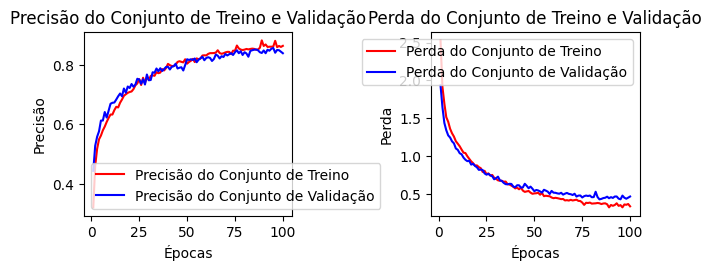

In [ ]:
classifier.evaluate_model(H)

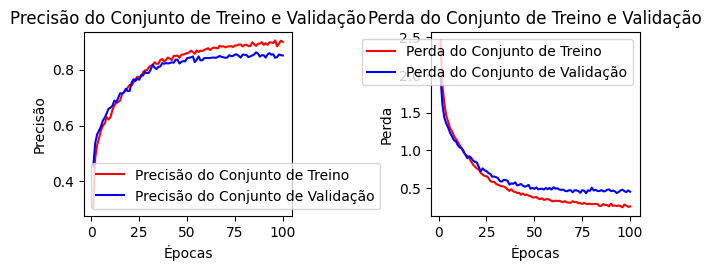

In [ ]:
classifier.evaluate_model(H)

In [ ]:
y_pred_classes = classifier.predict(X_test)
classifier.generate_report(y_test, y_pred_classes)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1691
              precision    recall  f1-score   support

           0       0.98      0.86      0.91        50
           1       0.60      0.75      0.67        12
           2       0.94      0.97      0.96        78
           3       1.00      0.73      0.84        26
           4       0.32      0.56      0.41        18
           5       1.00      0.76      0.86        29
           6       0.44      0.24      0.31        17
           7       0.86      0.97      0.91       179
           8       0.97      0.97      0.97       331
           9       0.29      1.00      0.44         2
          10       1.00      1.00      1.00         1
          11       0.88      0.67      0.76        21
          12       0.96      0.98      0.97       199
          13       0.68      0.50      0.58        68
          14       0.81      0.62      0.70       103
          15       0.61      0.62      0.61        65
          16       0.53      0.61    

#### Estudo de hiperparâmetros

##### Learning Rate

In [ ]:
#!pip uninstall -y scikit-learn scikeras
!pip install scikit-learn==1.0.2 scikeras==0.9.0

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

class IntentClassifierTest:
    def __init__(self, epochs=200, batch_size=16, validation_split=0.3, test_size=0.3):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        #self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, learning_rate, input_shape):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        #model.add(Dropout(0.3))
        model.add(LSTM(64))
        #model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()

        self.model = model
        #return self.model

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

Testando com taxa de aprendizado: 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1: f1-score: 0.0081 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1319 - loss: 66.8522 - val_accuracy: 0.1343 - val_loss: 2.8711 - f1_score: 0.0081 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1397 - loss: 2.9935 - val_accuracy: 0.1833 - val_loss: 2.9620 - f1_score: 0.0126 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1332 - loss: 3.0276 - val_accuracy: 0.1833 - val_loss: 2.9454 - f1_score: 0.0126 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1353 - loss: 3.0074 - val_accuracy: 0.1833 - val_loss: 3.0858 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/2

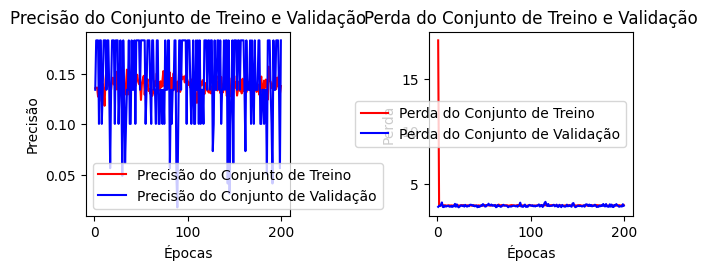

Testando com taxa de aprendizado: 0.1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1633 - loss: 2.9959 - val_accuracy: 0.1833 - val_loss: 2.7593 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1477 - loss: 2.7788 - val_accuracy: 0.1833 - val_loss: 2.7599 - f1_score: 0.0126 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1720 - loss: 2.7684 - val_accuracy: 0.1833 - val_loss: 2.7646 - f1_score: 0.0126 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1452 - loss: 2.7877 - val_accuracy: 0.1833 - val_loss: 2.7485 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/200

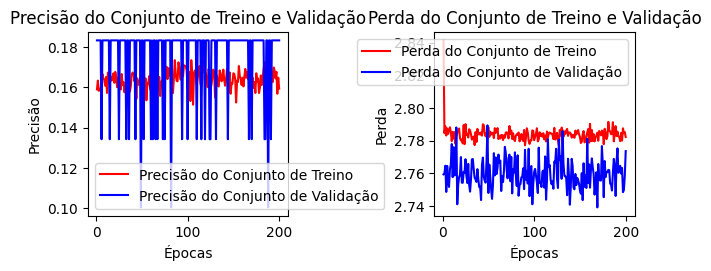

Testando com taxa de aprendizado: 0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1755 - recall: 0.2030
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3248 - loss: 2.3655 - val_accuracy: 0.5262 - val_loss: 1.6444 - f1_score: 0.1755 - recall: 0.2030
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.2580 - recall: 0.2776
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5275 - loss: 1.5759 - val_accuracy: 0.5608 - val_loss: 1.5063 - f1_score: 0.2580 - recall: 0.2776
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2757 - recall: 0.2905
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5900 - loss: 1.3717 - val_accuracy: 0.5904 - val_loss: 1.3272 - f1_score: 0.2757 - recall: 0.2905
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.3250 - recall: 0.3213
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6173 - loss: 1.2317 - val_accuracy: 0.6613 - val_loss: 1.1981 - f1_score: 0.3250 - recall: 0.3213
Epoch 5/200

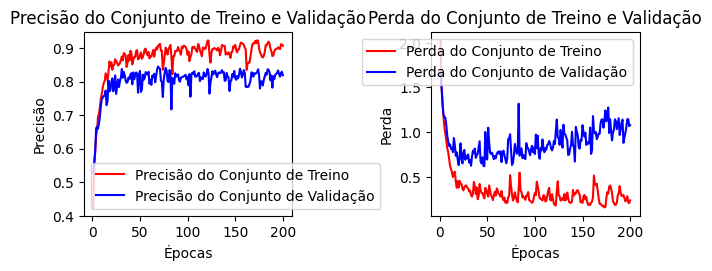

Testando com taxa de aprendizado: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1494 - recall: 0.1707
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2987 - loss: 2.7197 - val_accuracy: 0.4772 - val_loss: 1.8267 - f1_score: 0.1494 - recall: 0.1707
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1983 - recall: 0.2161
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4815 - loss: 1.8531 - val_accuracy: 0.5363 - val_loss: 1.5977 - f1_score: 0.1983 - recall: 0.2161
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2502 - recall: 0.2674
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5502 - loss: 1.5432 - val_accuracy: 0.6081 - val_loss: 1.3655 - f1_score: 0.2502 - recall: 0.2674
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2908 - recall: 0.3015
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6021 - loss: 1.3204 - val_accuracy: 0.6326 - val_loss: 1.2048 - f1_score: 0.2908 - recall: 0.3015
Epoch 5/200

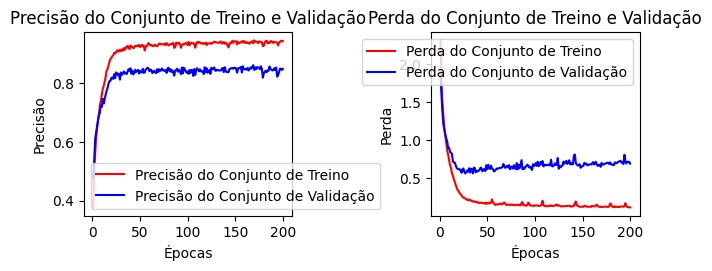

Testando com taxa de aprendizado: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0144 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1521 - loss: 3.2281 - val_accuracy: 0.1833 - val_loss: 2.9044 - f1_score: 0.0144 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0512 - recall: 0.0806
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1826 - loss: 2.7890 - val_accuracy: 0.3041 - val_loss: 2.4391 - f1_score: 0.0512 - recall: 0.0806
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0939 - recall: 0.1250
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3227 - loss: 2.3869 - val_accuracy: 0.4147 - val_loss: 2.2250 - f1_score: 0.0939 - recall: 0.1250
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.1039 - recall: 0.1372
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4008 - loss: 2.2564 - val_accuracy: 0.4552 - val_loss: 2.0543 - f1_score: 0.1039 - recall: 0.1372
Epoch 5/200

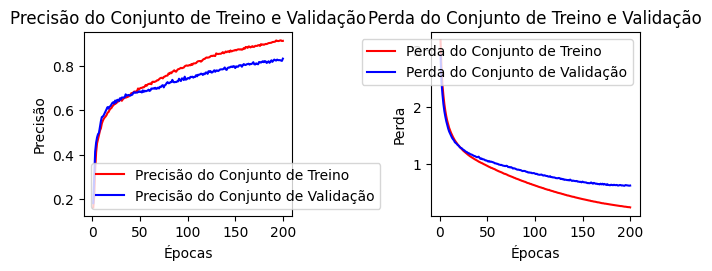

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1.0, 0.1, 0.01, 0.001, 0.0001]
}

grid = ParameterGrid(param_grid)

max_epochs = 30

results = []

for params in grid:
    print(f'Testando com taxa de aprendizado: {params["learning_rate"]}')
    classifiertest = IntentClassifierTest()
    X_train, X_test, y_train, y_test = classifiertest.prepare_data(chats_clients)
    classifiertest.build_model(learning_rate=params['learning_rate'], input_shape=(X_train.shape[1], X_train.shape[2]))
    #print(p)
    H = classifiertest.train(X_train, X_test, y_train, y_test)
    H
    classifiertest.evaluate_model(H)

Tendo em vista os resultados obtidos, vê se que a melhor curva de aprendizado ocorreu com a taxa de aprendizado em **0.0001**, apesar da acurácia ser de 82% a diferença entre as curvas de treino e teste podem indicar overfitting, que pode ser tratado com demais implementações.

Além disso, também é evidente que a taxa de **0.001** merece destaque, pela possibilidade de futuras melhoras com outros hiperparâmetros, mas uma acurácia já até mais positiva.

##### Dropout

In [ ]:
#!pip uninstall -y scikit-learn scikeras
!pip install scikit-learn==1.0.2 scikeras==0.9.0

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

class IntentClassifierTest:
    def __init__(self, epochs=200, batch_size=16, validation_split=0.3, test_size=0.3):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        #self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, learning_rate, dropout, input_shape):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(64))
        model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()

        self.model = model
        #return self.model

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

Testando com taxa de aprendizado: 0.1 e dropout: 0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1534 - loss: 2.9708 - val_accuracy: 0.1833 - val_loss: 2.7751 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1774 - loss: 2.7704 - val_accuracy: 0.1833 - val_loss: 2.7459 - f1_score: 0.0126 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1566 - loss: 2.8077 - val_accuracy: 0.1833 - val_loss: 2.7589 - f1_score: 0.0126 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1502 - loss: 2.7827 - val_accuracy: 0.1833 - val_loss: 2.7597 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/200

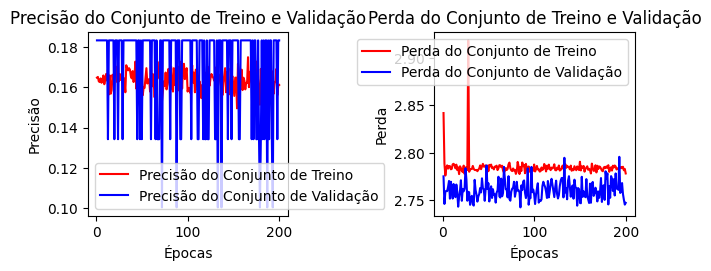

Testando com taxa de aprendizado: 0.0001 e dropout: 0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0356 - recall: 0.0619
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1863 - loss: 3.2230 - val_accuracy: 0.1909 - val_loss: 2.8927 - f1_score: 0.0356 - recall: 0.0619
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0522 - recall: 0.0852
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2557 - loss: 2.7189 - val_accuracy: 0.3159 - val_loss: 2.3656 - f1_score: 0.0522 - recall: 0.0852
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0623 - recall: 0.1037
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3169 - loss: 2.3852 - val_accuracy: 0.3826 - val_loss: 2.1816 - f1_score: 0.0623 - recall: 0.1037
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0956 - recall: 0.1267
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3891 - loss: 2.2071 - val_accuracy: 0.4231 - val_loss: 2.0589 - f1_score: 0.0956 - recall: 0.1267
Epoch 5/200

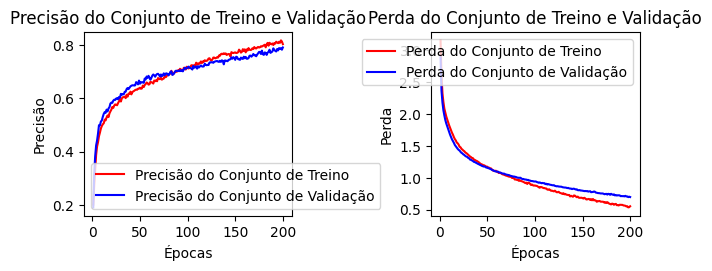

Testando com taxa de aprendizado: 0.1 e dropout: 0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1328 - loss: 2.9552 - val_accuracy: 0.1833 - val_loss: 2.7586 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0081 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1481 - loss: 2.7871 - val_accuracy: 0.1343 - val_loss: 2.7792 - f1_score: 0.0081 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1420 - loss: 2.8298 - val_accuracy: 0.1833 - val_loss: 2.7606 - f1_score: 0.0126 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1751 - loss: 2.7533 - val_accuracy: 0.1833 - val_loss: 2.7700 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/200

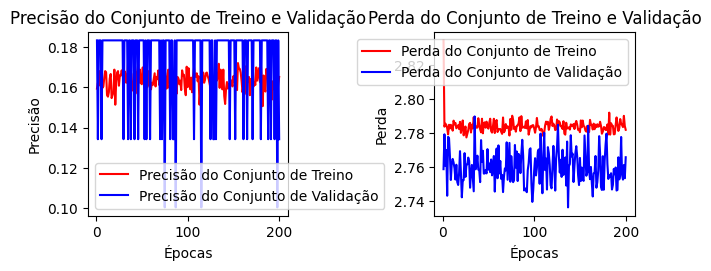

Testando com taxa de aprendizado: 0.0001 e dropout: 0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1580 - loss: 3.2366 - val_accuracy: 0.1833 - val_loss: 3.0362 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0144 - recall: 0.0393
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1638 - loss: 2.9178 - val_accuracy: 0.1833 - val_loss: 2.5833 - f1_score: 0.0144 - recall: 0.0393
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0447 - recall: 0.0770
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1865 - loss: 2.5962 - val_accuracy: 0.3007 - val_loss: 2.3850 - f1_score: 0.0447 - recall: 0.0770
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0610 - recall: 0.0987
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3033 - loss: 2.4239 - val_accuracy: 0.3657 - val_loss: 2.2244 - f1_score: 0.0610 - recall: 0.0987
Epoch 5/200

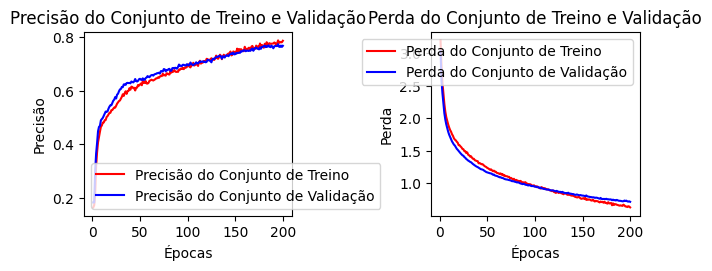

Testando com taxa de aprendizado: 0.1 e dropout: 0.4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1486 - loss: 2.9576 - val_accuracy: 0.1833 - val_loss: 2.7761 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1640 - loss: 2.7929 - val_accuracy: 0.1833 - val_loss: 2.7600 - f1_score: 0.0126 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0081 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1677 - loss: 2.7601 - val_accuracy: 0.1343 - val_loss: 2.7644 - f1_score: 0.0081 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1576 - loss: 2.7745 - val_accuracy: 0.1833 - val_loss: 2.7404 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/200

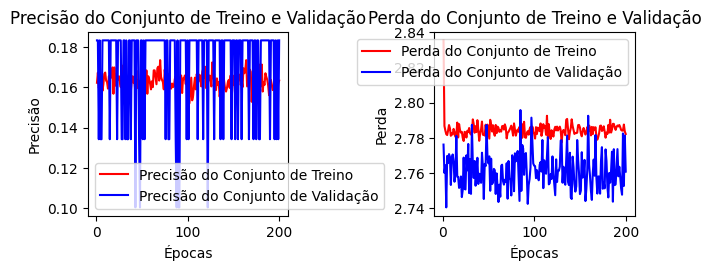

Testando com taxa de aprendizado: 0.0001 e dropout: 0.4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1342 - loss: 3.2388 - val_accuracy: 0.1833 - val_loss: 3.0792 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0331 - recall: 0.0677
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1672 - loss: 2.9728 - val_accuracy: 0.2627 - val_loss: 2.5985 - f1_score: 0.0331 - recall: 0.0677
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0329 - recall: 0.0721
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2607 - loss: 2.5886 - val_accuracy: 0.2720 - val_loss: 2.3819 - f1_score: 0.0329 - recall: 0.0721
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0529 - recall: 0.0880
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2738 - loss: 2.3909 - val_accuracy: 0.3252 - val_loss: 2.2498 - f1_score: 0.0529 - recall: 0.0880
Epoch 5/200

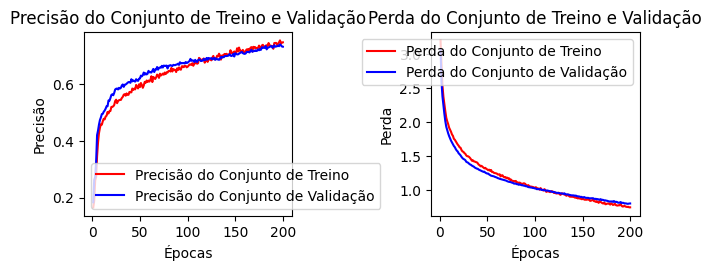

Testando com taxa de aprendizado: 0.1 e dropout: 0.5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_11 (Bidirectional)     │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0081 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1696 - loss: 2.9130 - val_accuracy: 0.1343 - val_loss: 2.7786 - f1_score: 0.0081 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1460 - loss: 2.7770 - val_accuracy: 0.1833 - val_loss: 2.7477 - f1_score: 0.0126 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1747 - loss: 2.7938 - val_accuracy: 0.1833 - val_loss: 2.7500 - f1_score: 0.0126 - recall: 0.0385
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0074 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1729 - loss: 2.7827 - val_accuracy: 0.1005 - val_loss: 2.7726 - f1_score: 0.0074 - recall: 0.0385
Epoch 5/200

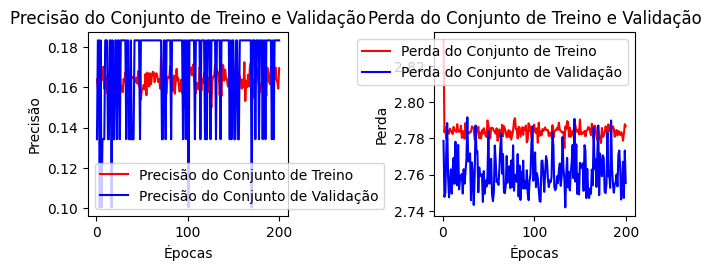

Testando com taxa de aprendizado: 0.0001 e dropout: 0.5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_12 (Bidirectional)     │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0131 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1202 - loss: 3.2452 - val_accuracy: 0.1833 - val_loss: 3.1331 - f1_score: 0.0131 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0297 - recall: 0.0492
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1814 - loss: 3.0260 - val_accuracy: 0.2095 - val_loss: 2.6273 - f1_score: 0.0297 - recall: 0.0492
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0463 - recall: 0.0807
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2392 - loss: 2.6206 - val_accuracy: 0.3074 - val_loss: 2.3774 - f1_score: 0.0463 - recall: 0.0807
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0502 - recall: 0.0864
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3055 - loss: 2.4191 - val_accuracy: 0.3328 - val_loss: 2.2462 - f1_score: 0.0502 - recall: 0.0864
Epoch 5/200

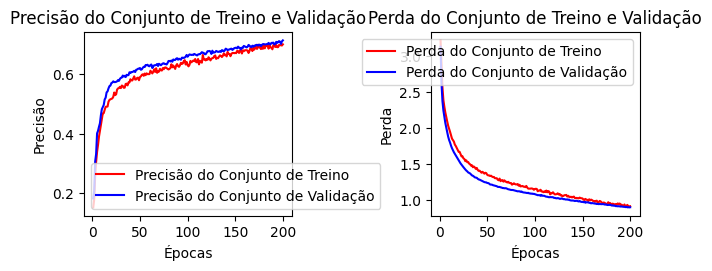

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.1, 0.0001],
    'dropout': [0.2, 0.3, 0.4, 0.5]
}

grid = ParameterGrid(param_grid)

max_epochs = 200

results = []

for params in grid:
    print(f'Testando com taxa de aprendizado: {params["learning_rate"]} e dropout: {params["dropout"]}')
    classifiertest = IntentClassifierTest()
    X_train, X_test, y_train, y_test = classifiertest.prepare_data(chats_clients)
    classifiertest.build_model(learning_rate=params['learning_rate'], dropout=params['dropout'], input_shape=(X_train.shape[1], X_train.shape[2]))
    #print(p)
    H = classifiertest.train(X_train, X_test, y_train, y_test)
    H
    classifiertest.evaluate_model(H)

Tendo em vista os resultados obtidos, vê se que a melhor curva de aprendizado ocorreu com a taxa de aprendizado em **0.0001** e o dropout de **0.4**, pela semelhança das curvas de treino e de teste, apesar da acurária diminuir um pouco para 70%.
O dropout de **0.5** com a mesma taxa de aprendizado também deve ser explorado em implementações futuras.


##### Batch Size

In [ ]:
#!pip uninstall -y scikit-learn scikeras
!pip install scikit-learn==1.0.2 scikeras==0.9.0

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

class IntentClassifierTest:
    def __init__(self, epochs=200, validation_split=0.3, test_size=0.3):
        self.epochs = epochs
        #self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        #self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, learning_rate, dropout, input_shape):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(64))
        model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()

        self.model = model
        #return self.model

    def train(self, X_train, X_test, y_train, y_test, batch_size):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

Testando com taxa de aprendizado: 0.0001, dropout: 0.4 e batch_size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1450 - loss: 3.2257 - val_accuracy: 0.1833 - val_loss: 2.9888 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0352 - recall: 0.0730
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1860 - loss: 2.8508 - val_accuracy: 0.2720 - val_loss: 2.5430 - f1_score: 0.0352 - recall: 0.0730
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0526 - recall: 0.0901
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2629 - loss: 2.5550 - val_accuracy: 0.3454 - val_loss: 2.3299 - f1_score: 0.0526 - recall: 0.0901
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0597 - recall: 0.0992
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3358 - loss: 2.3276 - val_accuracy: 0.3649 - val_loss: 2.1909 - f1_score: 0.0597 - recall: 0.0992
Epoch 5/200

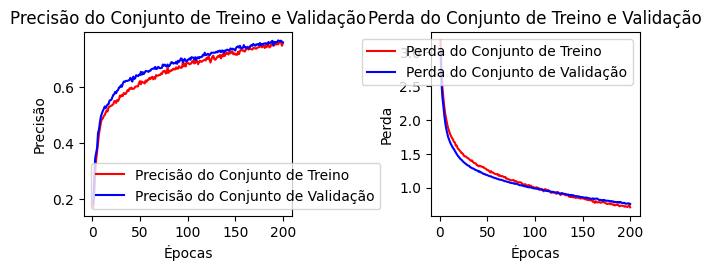

Testando com taxa de aprendizado: 0.0001, dropout: 0.5 e batch_size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1: f1-score: 0.0423 - recall: 0.0687
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0825 - loss: 3.2537 - val_accuracy: 0.2736 - val_loss: 3.2072 - f1_score: 0.0423 - recall: 0.0687
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0127 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2071 - loss: 3.1530 - val_accuracy: 0.1833 - val_loss: 2.7841 - f1_score: 0.0127 - recall: 0.0385
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0458 - recall: 0.0751
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1917 - loss: 2.7391 - val_accuracy: 0.2914 - val_loss: 2.5208 - f1_score: 0.0458 - recall: 0.0751
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0515 - recall: 0.0876
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2763 - loss: 2.5547 - val_accuracy: 0.3302 - val_loss: 2.3872 - f1_score: 0.0515 - recall: 0.0876
Epoch 5/200

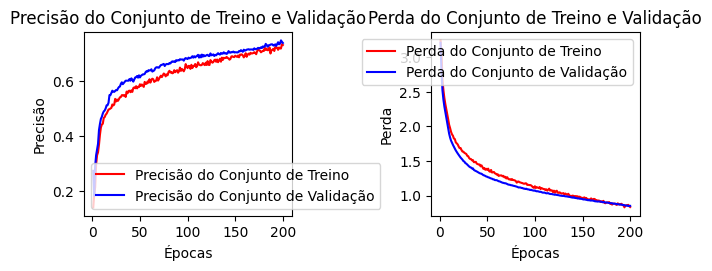

Testando com taxa de aprendizado: 0.0001, dropout: 0.4 e batch_size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0353 - recall: 0.0543
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0701 - loss: 3.2550 - val_accuracy: 0.2432 - val_loss: 3.2286 - f1_score: 0.0353 - recall: 0.0543
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0403 - recall: 0.0646
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2138 - loss: 3.2157 - val_accuracy: 0.2475 - val_loss: 3.1152 - f1_score: 0.0403 - recall: 0.0646
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0376 - recall: 0.0653
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2348 - loss: 3.0488 - val_accuracy: 0.2492 - val_loss: 2.6919 - f1_score: 0.0376 - recall: 0.0653
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0500 - recall: 0.0869
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2541 - loss: 2.6469 - val_accuracy: 0.3235 - val_loss: 2.3990 - f1_score: 0.0500 - recall: 0.0869
Epoch 5/200
53/5

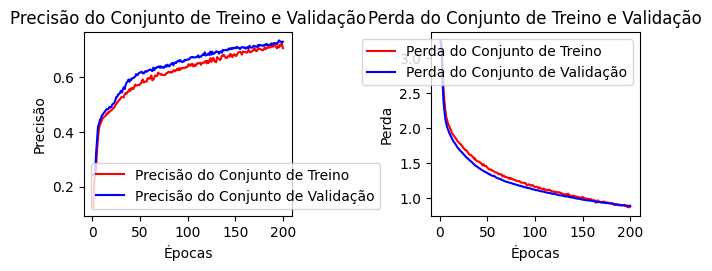

Testando com taxa de aprendizado: 0.0001, dropout: 0.5 e batch_size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1: f1-score: 0.0537 - recall: 0.0749
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0480 - loss: 3.2557 - val_accuracy: 0.2601 - val_loss: 3.2308 - f1_score: 0.0537 - recall: 0.0749
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0263 - recall: 0.0518
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1374 - loss: 3.2167 - val_accuracy: 0.1715 - val_loss: 3.1232 - f1_score: 0.0263 - recall: 0.0518
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0308 - recall: 0.0588
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1632 - loss: 3.0653 - val_accuracy: 0.1959 - val_loss: 2.8088 - f1_score: 0.0308 - recall: 0.0588
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0340 - recall: 0.0725
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2180 - loss: 2.8038 - val_accuracy: 0.2652 - val_loss: 2.5320 - f1_score: 0.0340 - recall: 0.0725
Epoch 5/200
53/5

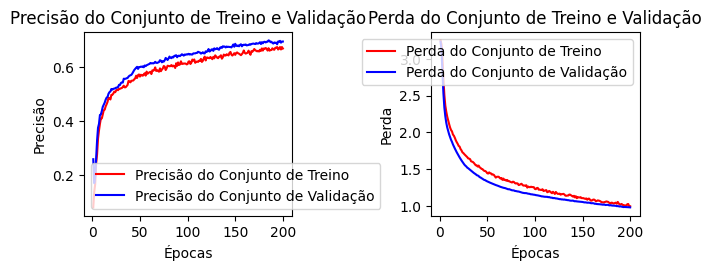

Testando com taxa de aprendizado: 0.0001, dropout: 0.4 e batch_size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0358 - recall: 0.0635
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.0608 - loss: 3.2528 - val_accuracy: 0.1309 - val_loss: 3.2334 - f1_score: 0.0358 - recall: 0.0635
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0376 - recall: 0.0711
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1227 - loss: 3.2263 - val_accuracy: 0.1715 - val_loss: 3.1870 - f1_score: 0.0376 - recall: 0.0711
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0427 - recall: 0.0628
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1687 - loss: 3.1725 - val_accuracy: 0.2035 - val_loss: 3.0785 - f1_score: 0.0427 - recall: 0.0628
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0376 - recall: 0.0683
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1823 - loss: 3.0461 - val_accuracy: 0.2382 - val_loss: 2.8691 - f1_score: 0.0376 - recall: 0.0683
Epoch 5/200
53/5

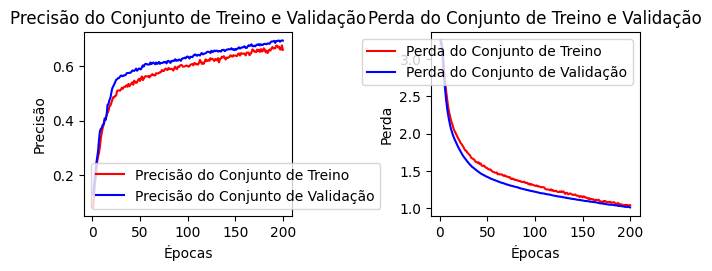

Testando com taxa de aprendizado: 0.0001, dropout: 0.5 e batch_size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0411 - recall: 0.0793
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0502 - loss: 3.2556 - val_accuracy: 0.2627 - val_loss: 3.2430 - f1_score: 0.0411 - recall: 0.0793
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0238 - recall: 0.0508
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1708 - loss: 3.2400 - val_accuracy: 0.2078 - val_loss: 3.2124 - f1_score: 0.0238 - recall: 0.0508
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0152 - recall: 0.0400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1863 - loss: 3.2063 - val_accuracy: 0.1875 - val_loss: 3.1480 - f1_score: 0.0152 - recall: 0.0400
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0126 - recall: 0.0385
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1727 - loss: 3.1324 - val_accuracy: 0.1833 - val_loss: 2.9957 - f1_score: 0.0126 - recall: 0.0385
Epoch 5/200
53/5

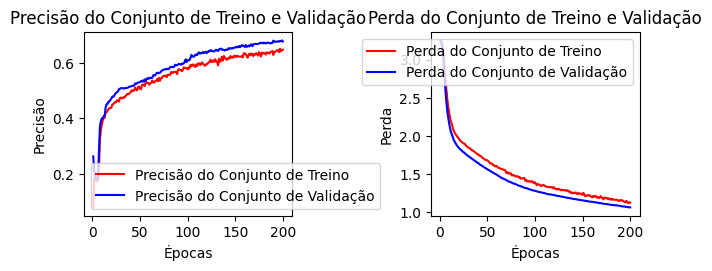

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.0001],
    'dropout': [0.4, 0.5],
    'batch_size': [16, 32, 64]
}

grid = ParameterGrid(param_grid)

max_epochs = 200

results = []

for params in grid:
    print(f'Testando com taxa de aprendizado: {params["learning_rate"]}, dropout: {params["dropout"]} e batch_size: {params["batch_size"]}')
    classifiertest = IntentClassifierTest()
    X_train, X_test, y_train, y_test = classifiertest.prepare_data(chats_clients)
    classifiertest.build_model(learning_rate=params['learning_rate'], dropout=params['dropout'], input_shape=(X_train.shape[1], X_train.shape[2]))
    #print(p)
    H = classifiertest.train(X_train, X_test, y_train, y_test, batch_size=params['batch_size'])
    H
    classifiertest.evaluate_model(H)

Tendo em vista os resultados obtidos, vê se que a melhor curva de aprendizado ocorreu com o batch_size de **16**, taxa de aprendizado **0.0001**, dropout **0.4**, pela curva de treino bem alinhada com a curva de teste. Nessa linha, o batch_size de **32** também pode trazer resultados significativos


##### Arquitetura da Rede - LSTM

In [ ]:
#!pip uninstall -y scikit-learn scikeras
!pip install scikit-learn==1.0.2 scikeras==0.9.0

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

class IntentClassifierTest:
    def __init__(self, epochs=200, validation_split=0.3, test_size=0.3):
        self.epochs = epochs
        #self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        #self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, learning_rate, dropout, lstm_units, input_shape):
        model = Sequential()
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(64))
        model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.summary()

        self.model = model
        #return self.model

    def train(self, X_train, X_test, y_train, y_test, batch_size):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

Testando com taxa de aprendizado: 0.001, dropout: 0.4, batch_size: 16 e lstm_units: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 1, 128)              │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,986 (550.73 KB)

 Trainable params: 140,986 (550.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1267 - recall: 0.1565
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2301 - loss: 2.9023 - val_accuracy: 0.4645 - val_loss: 1.8991 - f1_score: 0.1267 - recall: 0.1565
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1716 - recall: 0.2033
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4301 - loss: 1.9938 - val_accuracy: 0.5110 - val_loss: 1.6665 - f1_score: 0.1716 - recall: 0.2033
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.1836 - recall: 0.2098
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5052 - loss: 1.7032 - val_accuracy: 0.5346 - val_loss: 1.5121 - f1_score: 0.1836 - recall: 0.2098
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2344 - recall: 0.2606
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5320 - loss: 1.5784 - val_accuracy: 0.5642 - val_loss: 1.4358 - f1_score: 0.2344 - recall: 0.2606
Epoch 5/200

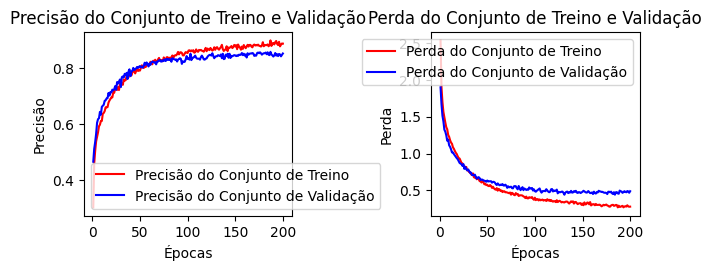

Testando com taxa de aprendizado: 0.001, dropout: 0.4, batch_size: 16 e lstm_units: 128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1197 - recall: 0.1517
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2346 - loss: 2.7820 - val_accuracy: 0.4679 - val_loss: 1.9467 - f1_score: 0.1197 - recall: 0.1517
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1745 - recall: 0.2043
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4563 - loss: 1.9627 - val_accuracy: 0.5279 - val_loss: 1.6017 - f1_score: 0.1745 - recall: 0.2043
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2368 - recall: 0.2575
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5257 - loss: 1.6233 - val_accuracy: 0.5541 - val_loss: 1.4370 - f1_score: 0.2368 - recall: 0.2575
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2642 - recall: 0.2929
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5391 - loss: 1.5033 - val_accuracy: 0.5845 - val_loss: 1.3794 - f1_score: 0.2642 - recall: 0.2929
Epoch 5/200

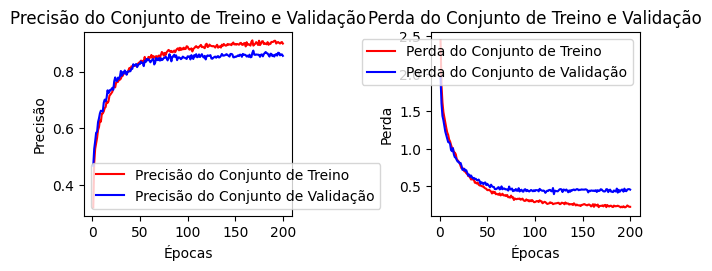

Testando com taxa de aprendizado: 0.001, dropout: 0.4, batch_size: 16 e lstm_units: 256


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 1, 512)              │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 885,946 (3.38 MB)

 Trainable params: 885,946 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1446 - recall: 0.1651
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1898 - loss: 2.7800 - val_accuracy: 0.4679 - val_loss: 1.8794 - f1_score: 0.1446 - recall: 0.1651
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1812 - recall: 0.2082
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4641 - loss: 1.9178 - val_accuracy: 0.5304 - val_loss: 1.6182 - f1_score: 0.1812 - recall: 0.2082
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2622 - recall: 0.2856
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5211 - loss: 1.6252 - val_accuracy: 0.5904 - val_loss: 1.3913 - f1_score: 0.2622 - recall: 0.2856
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2954 - recall: 0.3075
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5655 - loss: 1.4873 - val_accuracy: 0.6233 - val_loss: 1.2770 - f1_score: 0.2954 - recall: 0.3075
Epoch 5/200

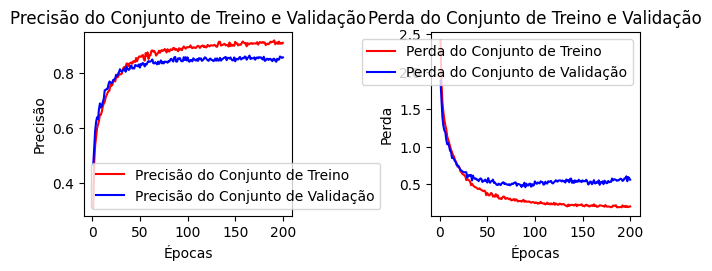

Testando com taxa de aprendizado: 0.0001, dropout: 0.4, batch_size: 16 e lstm_units: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_11 (Bidirectional)     │ (None, 1, 128)              │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,986 (550.73 KB)

 Trainable params: 140,986 (550.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0294 - recall: 0.0625
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0679 - loss: 3.2497 - val_accuracy: 0.1985 - val_loss: 3.1980 - f1_score: 0.0294 - recall: 0.0625
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0162 - recall: 0.0404
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1710 - loss: 3.1462 - val_accuracy: 0.1867 - val_loss: 2.8385 - f1_score: 0.0162 - recall: 0.0404
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0413 - recall: 0.0754
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2091 - loss: 2.7750 - val_accuracy: 0.2796 - val_loss: 2.5328 - f1_score: 0.0413 - recall: 0.0754
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0580 - recall: 0.0966
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2820 - loss: 2.5336 - val_accuracy: 0.3674 - val_loss: 2.3241 - f1_score: 0.0580 - recall: 0.0966
Epoch 5/200

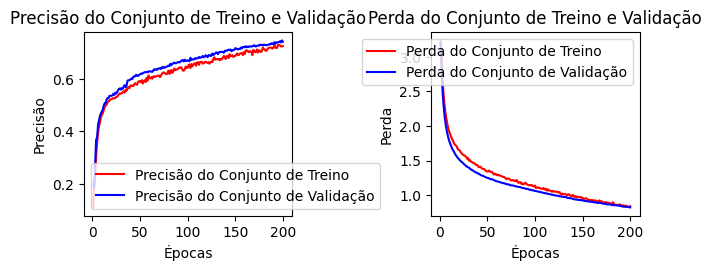

Testando com taxa de aprendizado: 0.0001, dropout: 0.4, batch_size: 16 e lstm_units: 128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_12 (Bidirectional)     │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0126 - recall: 0.0385
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1645 - loss: 3.2341 - val_accuracy: 0.1833 - val_loss: 3.0205 - f1_score: 0.0126 - recall: 0.0385
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0187 - recall: 0.0414
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1735 - loss: 2.8688 - val_accuracy: 0.1951 - val_loss: 2.5534 - f1_score: 0.0187 - recall: 0.0414
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0579 - recall: 0.0923
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2411 - loss: 2.5824 - val_accuracy: 0.3514 - val_loss: 2.3437 - f1_score: 0.0579 - recall: 0.0923
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0664 - recall: 0.1030
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3303 - loss: 2.3780 - val_accuracy: 0.3742 - val_loss: 2.1824 - f1_score: 0.0664 - recall: 0.1030
Epoch 5/200

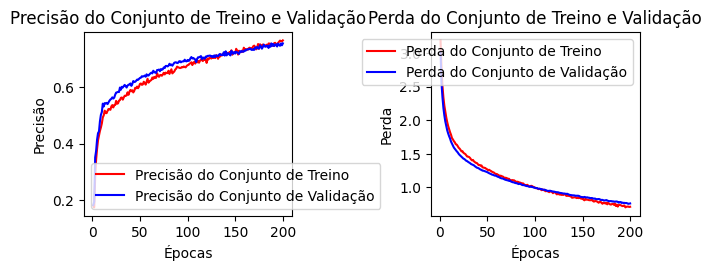

Testando com taxa de aprendizado: 0.0001, dropout: 0.4, batch_size: 16 e lstm_units: 256


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_13 (Bidirectional)     │ (None, 1, 512)              │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 64)                  │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 885,946 (3.38 MB)

 Trainable params: 885,946 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.0336 - recall: 0.0675
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1139 - loss: 3.2384 - val_accuracy: 0.2601 - val_loss: 3.0428 - f1_score: 0.0336 - recall: 0.0675
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.0341 - recall: 0.0728
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2604 - loss: 2.9006 - val_accuracy: 0.2703 - val_loss: 2.5048 - f1_score: 0.0341 - recall: 0.0728
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.0676 - recall: 0.1010
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2746 - loss: 2.5054 - val_accuracy: 0.3716 - val_loss: 2.2226 - f1_score: 0.0676 - recall: 0.1010
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.0936 - recall: 0.1287
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3764 - loss: 2.2529 - val_accuracy: 0.4215 - val_loss: 2.0365 - f1_score: 0.0936 - recall: 0.1287
Epoch 5/200

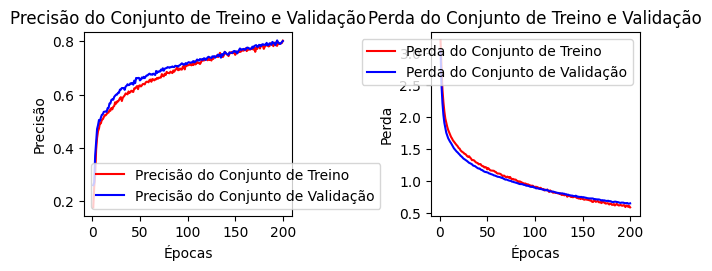

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001, 0.0001],
    'dropout': [0.4],
    'batch_size': [16],
    'lstm_units': [64, 128, 256]
}

grid = ParameterGrid(param_grid)

max_epochs = 200

results = []

for params in grid:
    print(f'Testando com taxa de aprendizado: {params["learning_rate"]}, dropout: {params["dropout"]}, batch_size: {params["batch_size"]} e lstm_units: {params["lstm_units"]}')
    classifiertest = IntentClassifierTest()
    X_train, X_test, y_train, y_test = classifiertest.prepare_data(chats_clients)
    classifiertest.build_model(learning_rate=params['learning_rate'], dropout=params['dropout'], lstm_units=params['lstm_units'], input_shape=(X_train.shape[1], X_train.shape[2]))
    #print(p)
    H = classifiertest.train(X_train, X_test, y_train, y_test, batch_size=params['batch_size'])
    H
    classifiertest.evaluate_model(H)

Tendo em vista os resultados obtidos, vê se que a melhor curva de aprendizado ocorreu com taxa de aprendizado: **0.001**, dropout: **0.4**, batch_size: **16** e lstm_units: **128**, obtendo também a maior acurácia.


#### Modelo Final

In [ ]:
class IntentClassifier:
    def __init__(self, epochs=300, batch_size=16, test_size=0.3, validation_split=0.3, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

In [ ]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
H = classifier.train(X_train, X_test, y_train, y_test)
H

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_14 (Bidirectional)     │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1190 - recall: 0.1558
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2136 - loss: 2.7929 - val_accuracy: 0.4780 - val_loss: 1.8895 - f1_score: 0.1190 - recall: 0.1558
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.1648 - recall: 0.2006
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4731 - loss: 1.9184 - val_accuracy: 0.5194 - val_loss: 1.6149 - f1_score: 0.1648 - recall: 0.2006
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.1936 - recall: 0.2320
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5282 - loss: 1.6397 - val_accuracy: 0.5515 - val_loss: 1.4822 - f1_score: 0.1936 - recall: 0.2320
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2324 - recall: 0.2598
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5322 - loss: 1.5125 - val_accuracy: 0.5845 - val_loss: 1.3701 - f1_score: 0.2324 - recall: 0.2598
Epoch 5/300

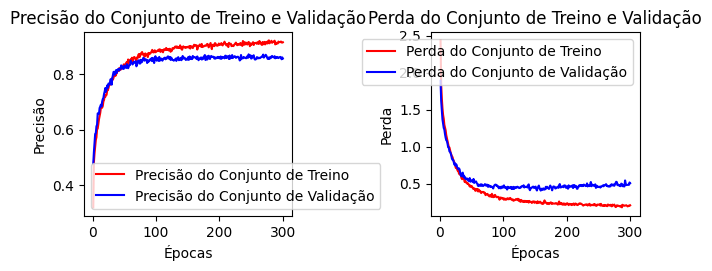

In [ ]:
classifier.evaluate_model(H)

In [ ]:
y_pred_classes = classifier.predict(X_test)
classifier.generate_report(y_test, y_pred_classes)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1691
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.56      0.75      0.64        12
           2       0.97      0.96      0.97        78
           3       0.93      1.00      0.96        26
           4       0.35      0.67      0.46        18
           5       0.93      0.90      0.91        29
           6       0.40      0.35      0.38        17
           7       0.89      0.95      0.92       179
           8       0.99      0.98      0.99       331
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         1
          11       1.00      0.71      0.83        21
          12       0.98      0.99      0.99       199
          13       0.63      0.63      0.63        68
          14       0.75      0.64      0.69       103
          15       0.77      0.55      0.64        65
          16       0.60      0.59    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Salvar o modelo treinado em extensão h5
classifier.model.save('intent_classifier_model.h5')

### Matriz de Confusão

A matriz de confusão avalia o desempenho do modelo. Os eixos Y representa as classes verdadeiras (true label) e o eixo x representa as classes previstas (predicted label). Além de indicar a frequência, as cores na matriz representam a intensidade dos valores nas células, ajudando a visualizar a frequência das classificações corretas e incorretas. Quanto mais escuro, mais frequente.

Cada célula na matriz indica o número de vezes que uma classe verdadeira foi prevista como classe específica. Já as células da diagonal principal indicam as instâncias onde o modelo previu corretamente.

#### Interpretação
* A célula (7, 7) tem 137 instâncias, indicando que 137 exemplos da classe 7 foram corretamente classificados como classe 7. Parece ser a classe mais corretamente classificada, com 142 instâncias corretas e poucas confusões com outras classes.

* A célula (11, 11) tem 68 instâncias, indicando que 68 exemplos da classe 11 foram corretamente classificados como classe 11.

* A célula (12, 3) mostra que 3 exemplos da classe 12 foram incorretamente classificados como classe 3.

* A célula (10, 12) mostra que 2 exemplos da classe 10 foram incorretamente classificados como classe 12.

É observado que a classe de índice 12, 16 e 10 mostra uma confusão e que o modelo trabalha bem com as classes 7 e 11. Conclui-se então que as células ao longo da diagonal principal indicam as instâncias onde o modelo previu corretamente a classe e por este motivo se destaca na matriz.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


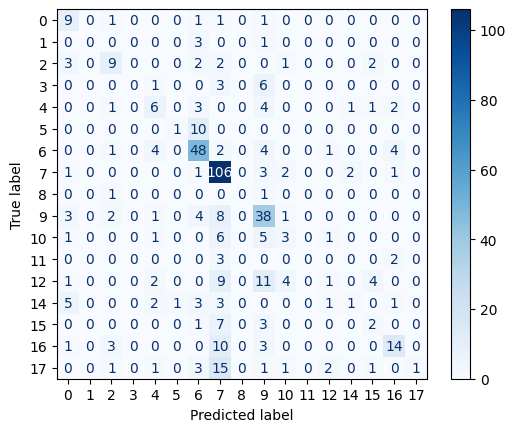

455
              precision    recall  f1-score   support

           0       0.38      0.69      0.49        13
           1       0.00      0.00      0.00         4
           2       0.47      0.47      0.47        19
           3       0.00      0.00      0.00        10
           4       0.33      0.33      0.33        18
           5       0.50      0.09      0.15        11
           6       0.61      0.75      0.67        64
           7       0.61      0.91      0.73       116
           8       0.00      0.00      0.00         2
           9       0.47      0.67      0.55        57
          10       0.25      0.18      0.21        17
          11       0.00      0.00      0.00         5
          12       0.17      0.03      0.05        32
          14       0.25      0.06      0.10        17
          15       0.20      0.15      0.17        13
          16       0.58      0.45      0.51        31
          17       1.00      0.04      0.07        26

    accuracy          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_classes = classifiertest.predict(X_test)

# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

classifiertest.generate_report(y_test, y_pred_classes)

## Testes

Nesta seção, é abordado os testes unitários que simulam o modelo. O objetivo é verificar se a função de vetorização e se o treinamento do classificador funcionam corretamente.

**fit**: Simula o comportamento do método fit do Keras, que é responsável por treinar a rede neural. Um histórico genérico e simulado é criado com valores de loss (perda), accuracy (acurácia), val_loss (perda na validação) e val_accuracy (acurácia na validação).

**evaluate**: Simula a avaliação do modelo, retornando uma perda de 0.3 e uma acurácia de 0.9.

**predict**: Simula a previsão do modelo, retornando probabilidades associadas às classes.

* Verificações:
  * Se o histórico de treino não é None.
  * Se o histórico contém registros de perda (loss).
  * Garante que os valores de perda não sejam NaN.
  * Comparação dos valores simulados de loss e accuracy retornados pela função evaluate.

* Teste da função de previsão (test_predict_function)
  * Objetivo: garantir que a função de previsão funcione corretamente após o treinamento.
  * Execução: a função train é chamada para treinar o modelo, seguida pela execução da função predict.
  * Verificações:
    Verifica se o número de previsões (y_pred_classes) corresponde ao número de amostras de teste (y_test).

* Teste com dados inválidos (test_invalid_data)
  * Objetivo: testar o funcionamento da função de treinamento quando tiver dados inválidos.
  * Execução: chamar a função train com arrays vazios para os dados de entrada e saída.
  * Verificação:
verificar se o ValueError é levantado quando os dados de treino são inválidos.

### Teste da Função de vetorização

In [ ]:
def get_vector(model, word):
    try:
        return model.wv[word]
    except KeyError:
        return None  # Retorna None se a palavra não estiver no vocabulário

In [ ]:
class TestWord2Vec(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        # Carregar o modelo Word2Vec apenas uma vez para todos os testes
        cls.model = model  # Supondo que o modelo já foi carregado em `model`

    def test_get_word_vector_present(self):
        word = 'dia'
        vector = get_vector(self.model, word)
        self.assertIsNotNone(vector, "O vetor para uma palavra presente deve ser diferente de None.")
        self.assertEqual(len(vector), 100, "O vetor deve ter 100 dimensões.")

    def test_get_no_word_vector(self):
        word = 'palavraInexistente'
        vector = get_vector(self.model, word)
        self.assertIsNone(vector, "O vetor para uma palavra ausente deve ser None.")

    def test_obter_vetor_input_invalido(self):
        word = 12345  # Um número em vez de uma string
        vector = get_vector(self.model, word)
        self.assertIsNone(vector, "O vetor para uma entrada inválida deve ser None.")

    def test_vetor_tamanho(self):
        word = 'bom'
        vector = get_vector(self.model, word)
        self.assertEqual(len(vector), 100, "O vetor deve ter 100 dimensões.")


### Teste do classificador de intenções

In [ ]:
class TestIntentClassifier(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        # Instanciando a classe `IntentClassifier`
        cls.classifier = IntentClassifier(epochs=20, batch_size=2)

        # Gerando dados fictícios para teste
        np.random.seed(42)
        cls.X_train = np.random.rand(10, 2, 300)  # samples, embeddings por sample, dimensão
        cls.y_train = np.random.randint(0, 3, size=(10,))  # 3 classes
        cls.X_test = np.random.rand(4, 2, 300)  # 4 samples de teste
        cls.y_test = np.random.randint(0, 3, size=(4,))

        # Simulação dos dados de `self.labels`
        cls.classifier.labels = cls.y_train  # Definição dos labels
        cls.classifier.build_model(input_shape=(2, 300))

    @patch('tensorflow.keras.Model.fit')
    @patch('tensorflow.keras.Model.evaluate')
    @patch('tensorflow.keras.Model.predict')
    def test_train_function(self, mock_predict, mock_evaluate, mock_fit):
        # Mockagem do método `fit` de treino
        mock_history = MagicMock()
        mock_history.history = {
            'loss': [0.5, 0.4, 0.3],
            'accuracy': [0.7, 0.8, 0.9],
            'val_loss': [0.6, 0.5, 0.4],
            'val_accuracy': [0.6, 0.7, 0.8]
        }
        mock_fit.return_value = mock_history

        # Mockagem do evaluate
        mock_evaluate.return_value = (0.3, 0.9)  # loss, accuracy

        # Mockagem do método`predict`
        mock_predict.return_value = np.array([[0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.1, 0.9]])

        history = self.classifier.train(self.X_train, self.X_test, self.y_train, self.y_test)

        # Verificações
        self.assertIsNotNone(history, "O histórico de treino não pode ser None")
        self.assertTrue(len(history.history['loss']) > 0, "Deve ter logs de perda no histórico")
        self.assertFalse(any(np.isnan(history.history['loss'])), "O valor de perda não deve ser NaN")
        self.assertEqual(mock_evaluate.return_value[0], 0.3, "O loss deve ser 0.3")
        self.assertEqual(mock_evaluate.return_value[1], 0.9, "A acurácia deve ser 0.9")

    def test_predict_function(self):
        # Teste da previsão após o treinamento
        self.classifier.train(self.X_train, self.X_test, self.y_train, self.y_test)
        y_pred_classes = self.classifier.predict(self.X_test)
        self.assertEqual(len(y_pred_classes), len(self.y_test), "O número de previsões deve ser igual ao número de testes")

    def test_invalid_data(self):
        # Teste com dados inválidos
        with self.assertRaises(ValueError):
            self.classifier.train(np.array([]), np.array([]), np.array([]), np.array([]))

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 2, 256)              │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 527,778 (2.01 MB)

 Trainable params: 527,778 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

.

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Epoch 1: f1-score: 0.2222 - recall: 0.3333
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.4286 - loss: nan - val_accuracy: 0.3333 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 2: f1-score: 0.2222 - recall: 0.3333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8524 - loss: nan - val_accuracy: 0.3333 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 3: f1-score: 0.2222 - recall: 0.3333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8524 - loss: nan - val_accuracy: 0.3333 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 4: f1-score: 0.2222 - recall: 0.3333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7190 - loss: nan - val_accuracy: 0.3333 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch

......
----------------------------------------------------------------------
Ran 7 tests in 6.867s

OK


Test Loss: 0.3, Test Accuracy: 0.9
